In [1]:
import os, sys
if not os.path.exists('./dl.yml'):
    os.chdir(os.path.expanduser('..'))
    
import numpy as np
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import mplcursors
from fastprogress.fastprogress import progress_bar as tqdm
from functools import partial
import cv2
from functools import partial

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils.dataloader2D import KBPDataset2D
# from config.config import config
from config.old_configs.run174.config import config

%matplotlib notebook
# %matplotlib inline

In [115]:
foldidx = 1
data_df = pd.read_csv(config.DATA_CSV_PATH)
split_train_mask = (data_df['Fold'] != 'Fold{}'.format(foldidx))
train_df = data_df[split_train_mask & (data_df['Split'] == 'Train')].reset_index(drop=True)
valid_df = data_df[(~split_train_mask) & (data_df['Split'] == 'Train')].reset_index(drop=True)
test_df = data_df[data_df['Split'] == 'Test'].reset_index(drop=True)
# train_ds = KBPDataset2D(config, train_df)
# valid_ds = KBPDataset2D(config, valid_df)
# test_ds = KBPDataset2D(config, test_df, training=False)

In [116]:
import models.model_list as model_list
from utils.dataloader import KBPDataset as KBPDataset3D
from utils.dataloader2D import KBPDataset2D
from torch.utils.data import Dataset, DataLoader
from utils.evaluation2D import EvaluateDose2D

Net = getattr(model_list, config.model_name)
net = Net(config=config).to(config.device)

metric = 'dose'
load_path = './model_weights/{}/models/best_{}_fold{}.pth'.format(config.exp_name, metric, foldidx)
assert config.exp_name in load_path
print('Loading model from {}'.format(load_path))
net.load_state_dict(torch.load(load_path)['model'])
net.float()
net.eval()
print('')

valid_ds3D = KBPDataset3D(config, valid_df)
valid_ds2D = KBPDataset2D(config, valid_df, valid=True)
valid_dl3D = DataLoader(valid_ds3D, batch_size=1, shuffle=False, num_workers=config.num_workers)
valid_dl2D = DataLoader(valid_ds2D, batch_size=1, shuffle=False, num_workers=config.num_workers)

Unet 2d separable conv with drop rate: 0.75
Loading model from ./model_weights/run174/models/best_dose_fold1.pth

Using Concat Dataset
Loading data along axis: 3


In [117]:
offset_lists = [np.arange(-4,5)]
dose_evaluator = EvaluateDose2D(config, net=net, data_loader=valid_dl3D, dose_loader=valid_dl2D, 
            offset_lists=offset_lists, load_cache=True, store_cache=False, cache_dir='localval_fold{}/{}/'.format(foldidx, metric))
# dvh_sc, dose_sc = dose_evaluator.make_metrics()
dose_score_vec, reference_dose_metric_df, new_dose_metric_df = dose_evaluator.make_metrics(get_dfs=True)
print('For this out-of-sample test:\n'
      '\tthe DVH score is {:.3f}\n '
      '\tthe dose score is {:.3f}'.format(dvh_sc, dose_sc))

Offset list:  [-4 -3 -2 -1  0  1  2  3  4]
Loading offset m4m3m2m101234 from cache...
Done inference! Making metrics...


NameError: name 'dvh_sc' is not defined

In [118]:
iidx = 0
sidx = 0
img, (target, possible_dose_mask, structure_masks, voxel_size, idx, is_pseudo) = valid_ds2D[iidx*128+sidx]
img.mean()

4.7448783

In [8]:
def info(img, x, y):
    x = np.round(x).astype('int')
    y = np.round(y).astype('int')
    val = img[y, x]
    line = "x={}, y={}, val={:.3f}".format(x, y, val)
    return line

def f(ds, dose_evaluator, dose_sc, voxel_sz, iidx=0, sidx=0):
    assert pd.DataFrame.equals(dose_evaluator.data_loader.dataset.data_df, ds.data_df)
    tidx = iidx*128+sidx
#     img, (target, possible_dose_mask, structure_masks, voxel_size, idx) = ds[tidx]
    
    dose_batch = ds.defdataset.get_batch(index=iidx)
    img = dose_batch['ct'][:,:,:,:,0]
    target = dose_batch['dose'][:,:,:,:,0]
    possible_dose_mask = dose_batch['possible_dose_mask'][:,:,:,:,0]
    structure_masks = dose_batch['structure_masks']
    voxel_size = dose_batch['voxel_dimensions']
    
    predidx = [0, np.s_[:], np.s_[:], np.s_[:]]
    predidx[config.axis] = sidx
    pred = dose_evaluator.preds[iidx][tuple(predidx)]
    
    arrays = [img[tuple(predidx)], target[tuple(predidx)], pred*possible_dose_mask[tuple(predidx)],
              possible_dose_mask[tuple(predidx)], pred]
    titles = ['Image', 'Target', 'Prediction*PDM', 'PDM', 'Prediction']
    fig, ax = plt.subplots(nrows=1, ncols=len(arrays), figsize=(len(arrays)*3,3))
    for a, arr, title in zip(ax, arrays, titles):
        a.imshow(arr)
        a.set_title(title)
        a.format_coord = partial(info, arr)
        a.axis('off')
    
    d_sc = possible_dose_mask[0].sum()
    if d_sc != 0:
        d_sc = np.abs(target[0]-pred*possible_dose_mask[0]).sum() / d_sc
    dose_sc.value = d_sc
    voxel_sz.value = str(voxel_size)
    
    mplcursors.cursor(hover=True)
    mplcursors.cursor(bindings={"toggle_visible": "h", "toggle_enabled": "e"}) # Shift+<arrow keys> to move
    fig.tight_layout()

In [9]:
ibt = widgets.BoundedIntText(value=0, min=0, max=len(valid_dl3D), step=1, description='Image Idx:', disabled=False)
isl = widgets.IntSlider(min=0, max=len(valid_dl3D), description='Image Idx:')
widgets.jslink((ibt, 'value'), (isl, 'value'))

sbt = widgets.BoundedIntText(value=76, min=0, max=127, step=1, description='Slice Idx:', disabled=False)
ssl = widgets.IntSlider(min=0, max=127, description='Slice Idx:')
widgets.jslink((sbt, 'value'), (ssl, 'value'))

dose_sc = widgets.BoundedFloatText(value=0, description='Dose Sc:', disabled=False)
voxel_sz = widgets.Text(value='', description='Voxel size:', disabled=False)

bts = widgets.HBox([ibt, sbt, voxel_sz])
sls = widgets.HBox([isl, ssl, dose_sc])
display(sls)

out = widgets.interactive_output(f, {'iidx': ibt, 'sidx': sbt, 'ds': fixed(valid_ds2D), 
                                     'dose_evaluator': fixed(dose_evaluator), 'dose_sc': fixed(dose_sc),
                                     'voxel_sz': fixed(voxel_sz)})

# interact(f, iidx=ibt, sidx=sbt, ds=fixed(train_ds))
display(bts, out)

Output()

In [122]:
# idx = 19
# subs = 0
mindoses = []
for idx in range(40):
    mindose = 20
    minsub = 0
    dor = valid_ds3D.defdataset.get_batch(idx)['dose'].flatten()
    pdm = valid_ds3D.defdataset.get_batch(idx)['possible_dose_mask']
    for subs in np.arange(-9, 10):
        dpr = ((dose_evaluator.preds[idx] - subs) * pdm.squeeze(4)).flatten()
        sdose = np.abs(dpr - dor).sum() / pdm.sum()
        if sdose < mindose:
            mindose = sdose
            minsub = subs
    mindoses.append(mindose)
    print(idx, mindose, minsub)
np.array(mindoses).mean()

0 1.2349217087570787 0
1 1.7532561885518647 0
2 2.251193877964016 0
3 2.646998421638844 -1
4 1.7549553366962207 0
5 2.380631559936884 0
6 1.8265931404743867 0
7 3.090139761651263 0
8 2.8152106350442856 0
9 2.655964207136281 0
10 2.9694565328071025 0
11 2.7599933192144865 0
12 1.5502286163160597 0
13 1.8955932296014992 0
14 3.8430743949416533 -1
15 2.4035411757329355 0
16 1.5348567225979153 0
17 1.446111556123899 0
18 1.619229267163659 0
19 2.8475437302895656 -2
20 1.6318483715681964 0
21 3.4744290780538196 4
22 2.9835393358857063 -1
23 2.3492414376819815 0
24 3.052025333716914 0
25 3.578995322397785 -1
26 1.5438840170229475 0
27 1.2362116133613765 0
28 2.417171485756602 0
29 2.0785746289267606 0
30 4.063980860934541 0
31 5.801138880085694 -2
32 1.4716503475637297 0
33 2.300545882576846 0
34 2.8737244731405704 0
35 3.5381178744208985 0
36 2.7498605560423175 0
37 1.4565497933371654 0
38 1.5911320879783186 0
39 2.0674963402509596 -1


2.4384902775835755

In [119]:
valid_df

,Id,Split,Fold,Type(Full/Head/Unclean/Bad)
0,./data/train-pats/pt_4,Train,Fold1,F
1,./data/train-pats/pt_9,Train,Fold1,F
2,./data/train-pats/pt_14,Train,Fold1,F
3,./data/train-pats/pt_18,Train,Fold1,H
4,./data/train-pats/pt_19,Train,Fold1,F
5,./data/train-pats/pt_28,Train,Fold1,F
6,./data/train-pats/pt_32,Train,Fold1,F
7,./data/train-pats/pt_33,Train,Fold1,H
8,./data/train-pats/pt_36,Train,Fold1,H
9,./data/train-pats/pt_37,Train,Fold1,H


In [113]:
data_df[(data_df['Type(Full/Head/Unclean/Bad)'] == 'B')]

,Id,Split,Fold,Type(Full/Head/Unclean/Bad)
37,./data/train-pats/pt_38,Train,Fold3,B
50,./data/train-pats/pt_51,Train,Fold0,B
88,./data/train-pats/pt_89,Train,Fold4,B
142,./data/train-pats/pt_143,Train,Fold1,B
169,./data/train-pats/pt_170,Train,Fold2,B
317,./data/test-pats/pt_318,MainTest,NaN,B
328,./data/test-pats/pt_329,MainTest,NaN,B


In [120]:
dose_score_vec.mean()

2.497245232400159

In [121]:
for i in enumerate(dose_score_vec):
    print(i)

(0, 1.2349217087570787)
(1, 1.7532561885518647)
(2, 2.251193877964016)
(3, 2.7768590398721202)
(4, 1.7549553366962207)
(5, 2.380631559936884)
(6, 1.8265931404743867)
(7, 3.090139761651263)
(8, 2.8152106350442856)
(9, 2.655964207136281)
(10, 2.9694565328071025)
(11, 2.7599933192144865)
(12, 1.5502286163160597)
(13, 1.8955932296014992)
(14, 3.9960151464009264)
(15, 2.4035411757329355)
(16, 1.5348567225979153)
(17, 1.446111556123899)
(18, 1.619229267163659)
(19, 3.1184575911260417)
(20, 1.6318483715681964)
(21, 4.768546735580359)
(22, 3.0708779843000826)
(23, 2.3492414376819815)
(24, 3.052025333716914)
(25, 3.6953635119820887)
(26, 1.5438840170229475)
(27, 1.2362116133613765)
(28, 2.417171485756602)
(29, 2.0785746289267606)
(30, 4.063980860934541)
(31, 6.068216490792162)
(32, 1.4716503475637297)
(33, 2.300545882576846)
(34, 2.8737244731405704)
(35, 3.5381178744208985)
(36, 2.7498605560423175)
(37, 1.4565497933371654)
(38, 1.5911320879783186)
(39, 2.0990771961535786)


## Test Predictions

In [28]:
metric = 'dose'
test_ds3D = KBPDataset3D(config, test_df, training=False)
test_ds2D = None  # KBPDataset2D(config, test_df, training=False, valid=True)
test_dl3D = DataLoader(test_ds3D, batch_size=1, shuffle=False, num_workers=config.num_workers)
test_dl2D = None  # DataLoader(test_ds2D, batch_size=1, shuffle=False, num_workers=config.num_workers)

In [76]:
config.exp_name = 'run164'  # 'run164'

In [77]:
offset_lists = [np.arange(-4,5)]
dose_evaluator0 = EvaluateDose2D(config, net=net, data_loader=test_dl3D, dose_loader=test_dl2D, 
            offset_lists=offset_lists, load_cache=True, store_cache=False, cache_dir='test_fold0/{}/'.format(metric))

Offset list:  [-4 -3 -2 -1  0  1  2  3  4]
Loading offset m4m3m2m101234 from cache...
Done inference! Making metrics...


In [78]:
offset_lists = [np.arange(-4,5)]
dose_evaluator1 = EvaluateDose2D(config, net=net, data_loader=test_dl3D, dose_loader=test_dl2D, 
            offset_lists=offset_lists, load_cache=True, store_cache=False, cache_dir='test_fold1/{}/'.format(metric))

Offset list:  [-4 -3 -2 -1  0  1  2  3  4]
Loading offset m4m3m2m101234 from cache...
Done inference! Making metrics...


In [99]:
iidx = 1
pdm = test_ds3D[iidx][1][1]['possible_dose_mask'][:,:,:,:,0]
d0 = dose_evaluator0.preds[iidx] * pdm
d1 = dose_evaluator1.preds[iidx] * pdm

In [100]:
d0.mean()

1.0891290104906943

In [101]:
d1.mean()

1.0935037827607061

In [102]:
np.abs(d0 - d1).mean()/pdm.mean()

0.643119038219804

In [12]:
import sys
del sys.modules['utils.dataloader2D'], resample
from utils.dataloader2D import resample

In [13]:
dose_batch = valid_ds2D.defdataset.get_batch(index=12)
img = dose_batch['ct'][:,:,:,:,0]
target = dose_batch['dose'][:,:,:,:,0]
voxel_sz = dose_batch['voxel_dimensions']

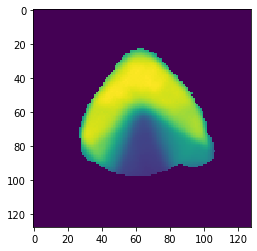

In [14]:
%matplotlib inline
plt.imshow(target[0,:,:,76])

In [15]:
targetrs = resample(target, voxel_sz, config.resample)

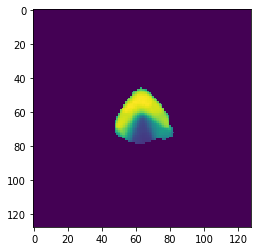

In [16]:
%matplotlib inline
plt.imshow(targetrs[0,:,:,76])

In [17]:
targetos = resample(targetrs, config.resample, voxel_sz)

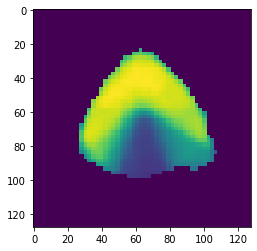

In [18]:
%matplotlib inline
plt.imshow(targetos[0,:,:,76])

In [20]:
(target>0).sum(), (targetos>0).sum()

(262146, 263908)

In [22]:
np.abs(target-targetos).mean()

0.2870138101577759

## Data Augmentation

In [3]:
# from albumentations.core.transforms_interface import DualTransform, to_tuple
try:
    del sys.modules['utils.preprocessing2D'], get_train_tfms, MonaiElastic, MonaiAffine, HorizontalFlip, RandomScale, RandomShift, RandomRotate, MultiplicativeNoise, Presize, Diffeomorph
    del sys.modules['utils.dataloader2D'], transform_item2D, KBPDataset2D
except:
    print('not deleting')
os.chdir(os.getcwd())
from utils.preprocessing2D import get_train_tfms, MonaiElastic, MonaiAffine, HorizontalFlip, RandomScale, RandomShift, RandomRotate, MultiplicativeNoise, Presize, Diffeomorph
from utils.dataloader2D import transform_item2D, KBPDataset2D

from albumentations import Compose, to_tuple, OneOf

not deleting


In [101]:
aug = HorizontalFlip(config.axis)

In [11]:
aug = RandomScale(scale_limit=0.5)

In [161]:
aug = RandomShift(shift_limit=20)

In [226]:
aug = RandomRotate(max_angle=20)

In [47]:
aug = MultiplicativeNoise(elementwise=False)

In [4]:
aug = Presize(zoom_limit=2)

In [13]:
aug = Diffeomorph(p=1)

In [4]:
aug = MonaiAffine(p=1)

In [4]:
aug = MonaiElastic(p=1)

In [32]:
aug = Compose([
    HorizontalFlip(config.axis),
#     Presize(zoom_limit=2), 
    RandomScale(scale_limit=0.2),
    RandomShift(shift_limit=4),
    RandomRotate(max_angle=3),
    Diffeomorph()
])

In [4]:
aug = get_train_tfms(config)

In [5]:
train_ds = KBPDataset2D(config, train_df[:5])

Loading data along axis: 3


6600794.0 6515053.0
2713.0 2713.0


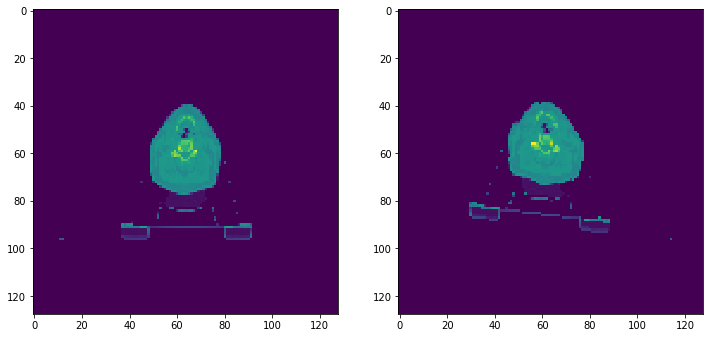

In [9]:
iidx = 0
idx= 57
train_ds.transform = None
img, (target, possible_dose_mask, structure_masks, voxel_size, _) = train_ds[iidx*128 + idx]
train_ds.transform = aug
tfimg, (tftarget, tfpossible_dose_mask, tfstructure_masks, tfvoxel_size, _) = train_ds[iidx*128 + idx]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
print(img.sum(), tfimg.sum())
print(img.max(), tfimg.max())
ax[0].imshow(img[0])
ax[1].imshow(tfimg[0])

In [10]:
%%time
print(np.array_equal(tfimg, img))
print(np.array_equal(tftarget, target))
print(np.array_equal(tfpossible_dose_mask, possible_dose_mask))
print(np.array_equal(tfstructure_masks, structure_masks))

False
False
False
False
CPU times: user 2.68 ms, sys: 316 µs, total: 2.99 ms
Wall time: 1.87 ms


In [11]:
tfimg.shape

(84, 128, 128)

148 1
148 1


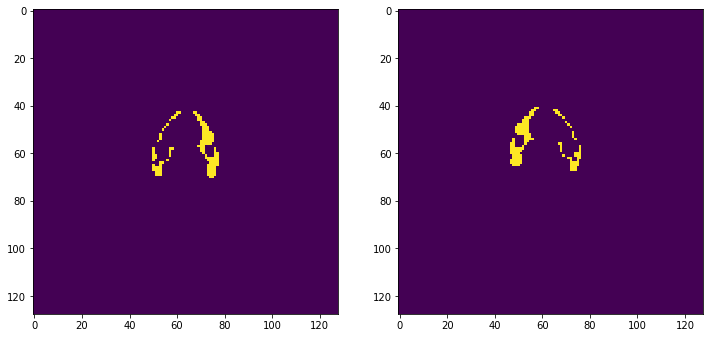

In [18]:
ch = 21
print(img[ch].sum().astype('int'), img[ch].max().astype('int'))
print(tfimg[ch].sum().astype('int'), tfimg[ch].max().astype('int'))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(img[ch])
ax[1].imshow(tfimg[ch])

48691.47 72.458
48121.27 72.458


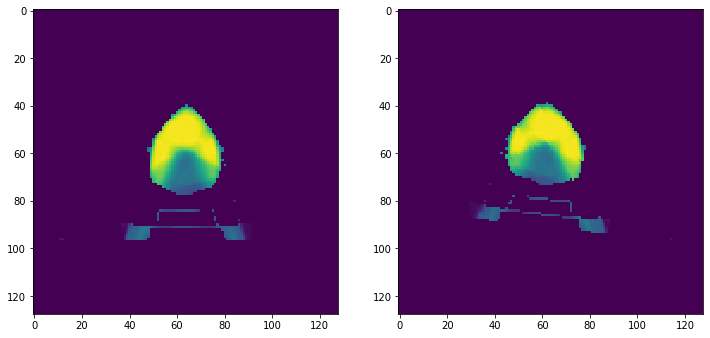

In [13]:
print(target[0].sum(), target[0].max())
print(tftarget[0].sum(), tftarget[0].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(target[0])
ax[1].imshow(tftarget[0])

1059.0 1.0
1047.0 1.0


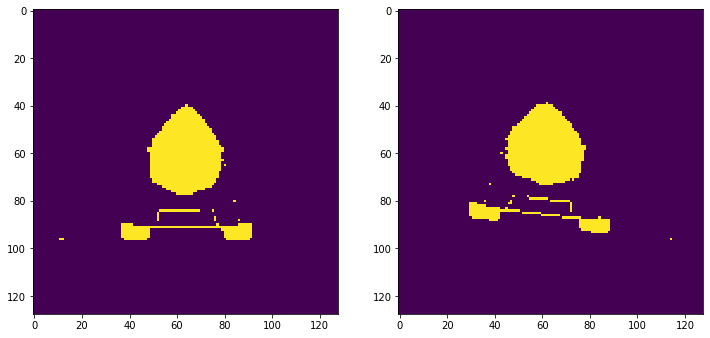

In [14]:
print(possible_dose_mask[0].sum(), possible_dose_mask[0].max())
print(tfpossible_dose_mask[0].sum(), tfpossible_dose_mask[0].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(possible_dose_mask[0])
ax[1].imshow(tfpossible_dose_mask[0])

111.0 1.0
114.0 1.0


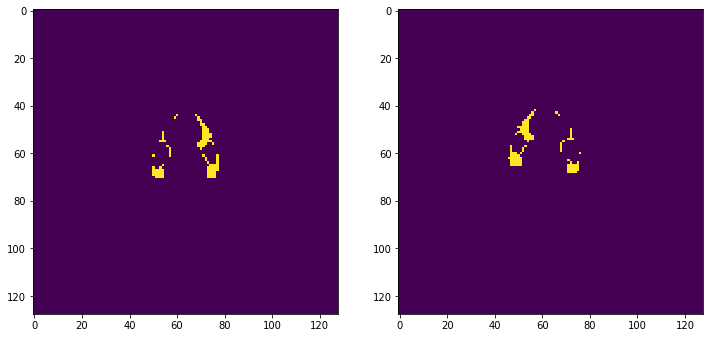

In [15]:
ch = 7
print(structure_masks[ch].sum(), structure_masks[ch].max())
print(tfstructure_masks[ch].sum(), tfstructure_masks[ch].max())
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax[0].imshow(structure_masks[ch])
ax[1].imshow(tfstructure_masks[ch])

In [79]:
mean = 0
maxv = 0
vals = []
tarvals = []
for idx in tqdm(range(len(train_ds))):
    img, (target, possible_dose_mask, structure_masks, voxel_size, idx) = train_ds[idx]
    mean += img.mean()
    maxv = max(maxv, img.max())
    vals.append(img.flatten())
    tarvals.append(target.flatten())
mean /= len(train_ds)
maxv, mean

(28036.0, 88.15740192532539)

In [80]:
valscomb = np.array(vals).flatten()
tarcomb = np.array(tarvals).flatten()

In [66]:
nzind = np.where(valscomb != 0)
valsnz = np.array(valscomb[nzind])

In [82]:
tnzind = np.where(tarcomb != 0)
tvalsnz = np.array(tarcomb[tnzind])

(array([4.5009530e+06, 9.9888800e+05, 8.7306000e+05, 2.2487894e+07,
        2.0191410e+06, 8.0731500e+05, 4.3645500e+05, 2.8768000e+05,
        1.6468200e+05, 3.2326000e+04, 5.4150000e+03, 2.3470000e+03,
        1.2510000e+03, 9.3200000e+02, 6.3080000e+03, 5.1000000e+01,
        4.9000000e+01, 2.6700000e+02, 1.6000000e+01, 2.0000000e+01,
        2.1000000e+01, 1.3000000e+01, 1.5000000e+01, 1.6000000e+01,
        7.0000000e+00, 1.0000000e+01, 8.0000000e+00, 1.0000000e+01,
        7.0000000e+00, 8.0000000e+00, 6.0000000e+00, 3.0000000e+00,
        1.5000000e+01, 4.0000000e+00, 4.0000000e+00, 7.0000000e+00,
        9.0000000e+00, 4.0000000e+00, 5.0000000e+00, 5.0000000e+00,
        4.0000000e+00, 4.0000000e+00, 5.0000000e+00, 3.0000000e+00,
        3.0000000e+00, 5.0000000e+00, 7.0000000e+00, 7.0000000e+00,
        3.0000000e+00, 5.0000000e+00, 4.0000000e+00, 3.0000000e+00,
        3.0000000e+00, 3.0000000e+00, 3.0000000e+00, 2.0000000e+00,
        4.0000000e+00, 3.0000000e+00, 4.0000000e

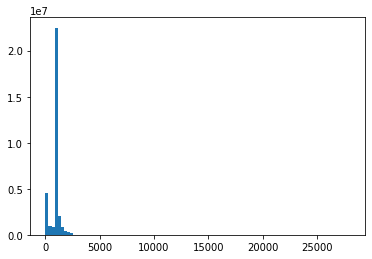

In [73]:
plt.hist(valsnz, bins=100)

(array([5.022759e+06, 9.328430e+05, 7.601350e+05, 5.884120e+05,
        4.670710e+05, 3.849150e+05, 3.305120e+05, 2.949960e+05,
        2.760980e+05, 2.640850e+05, 2.550350e+05, 2.459110e+05,
        2.391600e+05, 2.341000e+05, 2.313400e+05, 2.298070e+05,
        2.304060e+05, 2.313760e+05, 2.295680e+05, 2.267750e+05,
        2.250440e+05, 2.249310e+05, 2.255570e+05, 2.236790e+05,
        2.214590e+05, 2.192270e+05, 2.166310e+05, 2.127050e+05,
        2.099190e+05, 2.046070e+05, 1.982670e+05, 1.921990e+05,
        1.864010e+05, 1.794540e+05, 1.741080e+05, 1.681720e+05,
        1.632560e+05, 1.581630e+05, 1.545910e+05, 1.509650e+05,
        1.470040e+05, 1.441240e+05, 1.415870e+05, 1.399530e+05,
        1.373260e+05, 1.351200e+05, 1.340110e+05, 1.327090e+05,
        1.304840e+05, 1.291170e+05, 1.278560e+05, 1.249740e+05,
        1.233370e+05, 1.213100e+05, 1.200010e+05, 1.183260e+05,
        1.164360e+05, 1.154900e+05, 1.149600e+05, 1.147690e+05,
        1.142320e+05, 1.143170e+05, 1.14

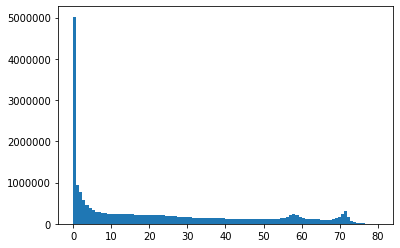

In [83]:
plt.hist(tvalsnz, bins=100)

In [81]:
tarcomb

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [84]:
valid_ds[0][1][0].max()

74.233